# Object Active Exploration to Peg in Hole

In [144]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from tqdm import trange
import seaborn as sns
from matplotlib import cm

import models

%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize objects


In [145]:
# object paramters
obj_shape = torch.tensor([0.04, 0.03, 0.02])
bound_range = 0.06
obs_width = 0.01
step = 0.001
noise_scale = 0.01

# generate cube
# xs = torch.arange(-obj_shape[0]/2, obj_shape[0]/2+step, step=step)
xs = torch.linspace(-0.5, 0.5, steps=11)
# ys = torch.arange(-obj_shape[1]/2, obj_shape[1]/2+step, step=step)
ys = torch.linspace(-0.5, 0.5, steps=11)
# zs = torch.arange(-obj_shape[2]/2, obj_shape[2]/2+step, step=step)
zs = torch.linspace(-0.5, 0.5, steps=11)

xp_face = torch.stack(torch.meshgrid(torch.ones(1)*0.5, ys, zs), dim=-1).view(-1, 3)
xn_face = torch.stack(torch.meshgrid(-torch.ones(1)*0.5, ys, zs), dim=-1).view(-1, 3)
yp_face = torch.stack(torch.meshgrid(xs, torch.ones(1)*0.5, zs), dim=-1).view(-1, 3)
yn_face = torch.stack(torch.meshgrid(xs, -torch.ones(1)*0.5, zs), dim=-1).view(-1, 3)
zp_face = torch.stack(torch.meshgrid(xs, ys, torch.ones(1)*0.5), dim=-1).view(-1, 3)
zn_face = torch.stack(torch.meshgrid(xs, ys, -torch.ones(1)*0.5), dim=-1).view(-1, 3)

identity_cube = torch.cat((xp_face, xn_face, yp_face, yn_face, zp_face, zn_face), dim=0)
cube = identity_cube * obj_shape
cube_noisy = (identity_cube + torch.randn_like(identity_cube) * noise_scale) * obj_shape

# generate observation
mask_z = (torch.abs(cube[:, 0]) > (obj_shape[0]/2 - step*0.01)) | (torch.abs(cube[:, 1]) > (obj_shape[1]/2 - step*0.01))
obs_z = identity_cube[mask_z, :] 
obs_z = (obs_z + torch.randn_like(obs_z) * noise_scale)*obj_shape


mask_x = torch.abs(cube[:, 0]) < obs_width 
obs_x = cube_noisy[mask_x, :]

mask_x = torch.abs(cube[:, 0]) < obj_shape[0]/2 
obs_x_full = cube_noisy[mask_x, :]

mask_y = torch.abs(cube[:, 1]) < obs_width
obs_y = cube_noisy[mask_y, :]

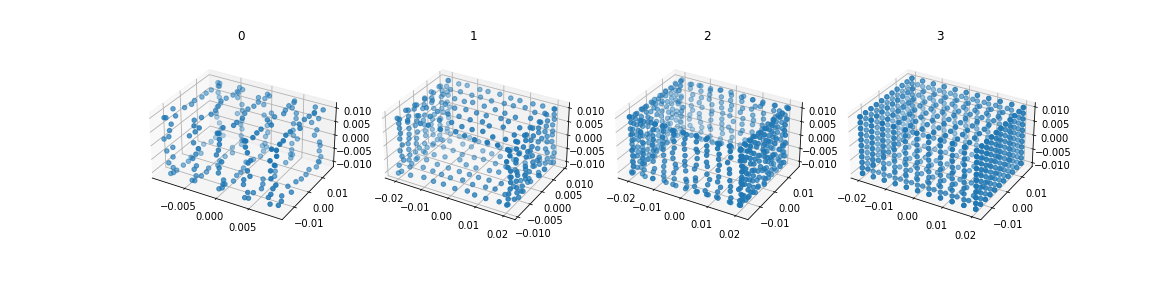

In [146]:
fig = plt.figure(figsize=(16,4))

for i, data in enumerate([obs_x, obs_y, obs_z, cube]):
  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  ax.set_box_aspect(obj_shape)
  ax.scatter(data[:,0].numpy(), data[:,1].numpy(), data[:,2])
  ax.title.set_text(f'{i}')

In [147]:

# Parameters:
theta = torch.linspace(0, 2*np.pi, 20)
phi = torch.linspace(0, np.pi, 20)
theta, phi = torch.meshgrid(theta, phi)
rho = bound_range
# Parametrization:
outter = torch.stack([rho*np.cos(theta)*np.sin(phi), rho*np.sin(theta)*np.sin(phi), rho*np.cos(phi)], dim=-1).view(-1, 3)
inner = torch.zeros((1,3))

In [148]:
outter = identity_cube * obj_shape.max() * 1.7

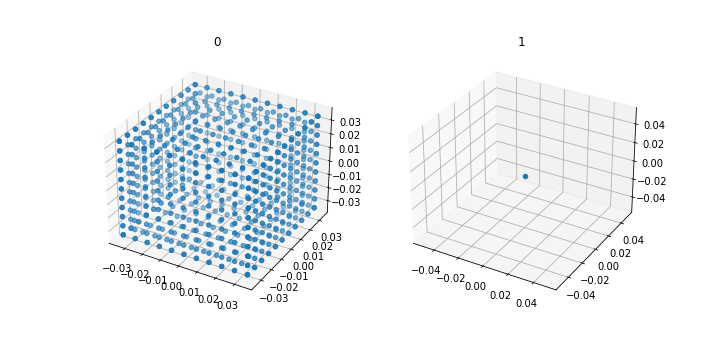

In [149]:
fig = plt.figure(figsize=(10,5))

for i, data in enumerate([outter, inner]):
  ax = fig.add_subplot(1, 2, i+1, projection='3d')
  ax.scatter(data[:,0].numpy(), data[:,1].numpy(), data[:,2].numpy())
  ax.title.set_text(f'{i}')

## Train with First Grasp

In [170]:
x_train = torch.cat((obs_z, outter, inner), dim=0) / obj_shape
f_train = torch.cat([
  torch.zeros(obs_z.shape[0]),
  torch.ones(outter.shape[0]),
  -torch.ones(inner.shape[0])
], dim=0)


## Train with Second Grasp 

In [209]:
x_train = torch.cat((obs_z, obs_x, outter, inner), dim=0) / obj_shape
f_train = torch.cat([
  torch.zeros(obs_z.shape[0]),
  torch.zeros(obs_x.shape[0]),
  torch.ones(outter.shape[0]),
  -torch.ones(inner.shape[0])
], dim=0)

In [210]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
b_like = gpytorch.likelihoods.BernoulliLikelihood()
model = models.thinPlateModel(x_train, f_train, likelihood)
hypers = {
  'likelihood.noise_covar.noise': 0.03,
  'covar_module.max_dist': torch.tensor(7.8),
  # 'covar_module.base_kernel.lengthscale': torch.tensor(0.6),
}
model_params = model.initialize(**hypers)

In [211]:
training_iter = 30

# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in (pbar := trange(training_iter)):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  
  # Output from model
  output = model(x_train)
  loss = -mll(output, f_train)
  loss.backward()
  pbar.set_description('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.max_dist, # model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
  optimizer.step()

Iter 30/30 - Loss: 0.272   lengthscale: 7.856   noise: 0.017: 100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


In [212]:
resolusion = 50

model.eval()
likelihood.eval()

xs = torch.linspace(-1, 1, steps=resolusion + 1)
ys = torch.linspace(-1, 1, steps=resolusion + 1)
zs = torch.linspace(-1, 1, steps=resolusion + 1)
x_test = torch.stack(torch.meshgrid(xs, ys, zs), dim=-1).view(-1, 3)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  distri = model(x_test)
  f_test = likelihood(distri)
  b_test = b_like(distri)
# f_test_mu = f_test.mean.view(resolusion+1, resolusion+1, resolusion+1)

In [213]:
f_test_mu = f_test.mean.view(resolusion+1, resolusion+1, resolusion+1)
f_test_var = f_test.variance.view(resolusion+1, resolusion+1, resolusion+1)

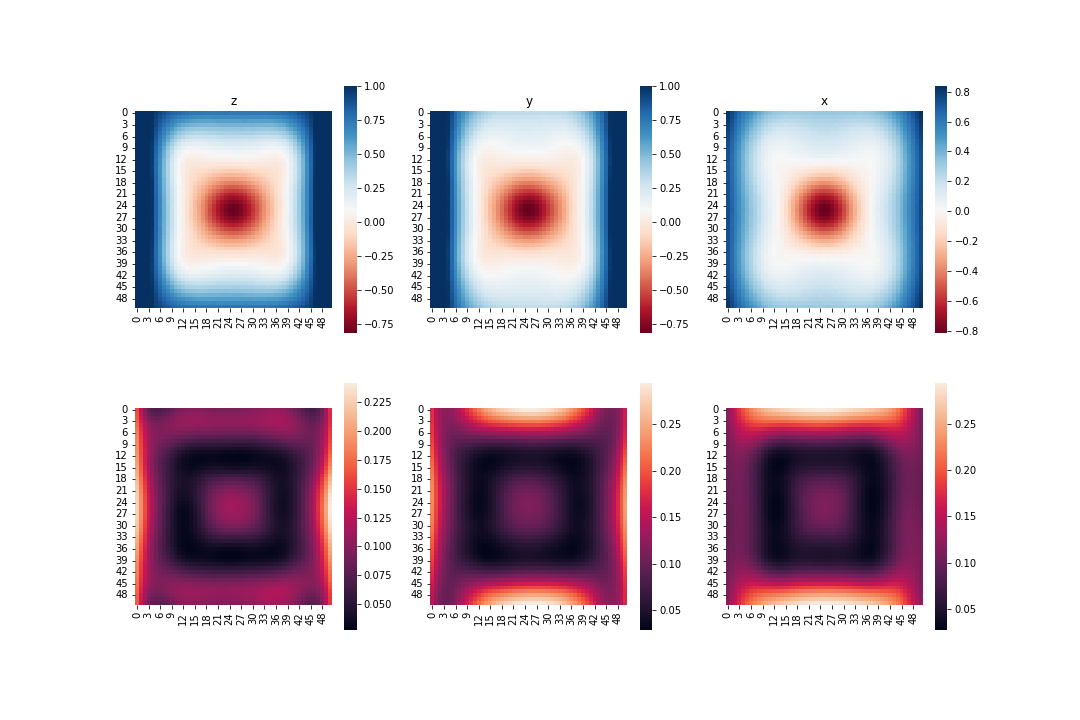

In [214]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

f_test_mu = torch.clip(f_test_mu, -1, 1).view(resolusion+1, resolusion+1, resolusion+1)

pp = torch.linspace(0,resolusion,resolusion+1)
ii, jj = np.meshgrid(pp, pp)

title=['z', 'y', 'x']
x_test_view = x_test.view(resolusion+1, resolusion+1, resolusion+1, 3)
for i, (var, mu) in enumerate([
  (f_test_var[:, :, resolusion//2], f_test_mu[:,:,resolusion//2]), 
  (f_test_var[:, resolusion//2, :], f_test_mu[:,resolusion//2,:]),
  (f_test_var[resolusion//2, :, :], f_test_mu[resolusion//2,:]),
]):
  sns.heatmap(mu.transpose(0,1).numpy(), square=True,  cmap="RdBu", ax=axes[0, i])
  sns.heatmap(var.transpose(0,1).detach().numpy(), square=True,  ax=axes[1, i])
  # mask = (np.abs(data) < 0.03)
  # axes[i].scatter(ii[mask], jj[mask], color='g')
  axes[0, i].title.set_text(title[i])

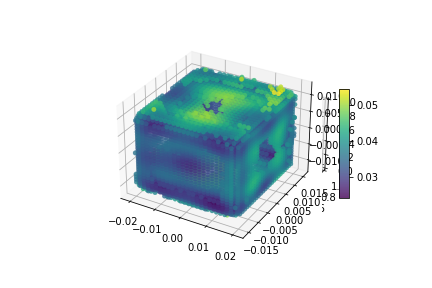

In [215]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(obj_shape)
mask = (np.abs(f_test_mu) < 2e-2)
surface = x_test.view(resolusion+1, resolusion+1, resolusion+1,3)[mask,:] * obj_shape
var = f_test_var[mask].detach().numpy()
ax = plt.axes(projection='3d')
ax.scatter(surface[:,0], surface[:,1], surface[:,2], c=var, cmap='viridis', alpha=0.8, linewidths=0.3)
fig.colorbar(ax.collections[0], shrink=0.5, aspect=10)
# ax.scatter(cube[:,0], cube[:,1], cube[:,2], c='r', marker='x', alpha=0.8, linewidths=1)

## Analyze the model

In [216]:
eval_x = torch.cat((
  yp_face, yn_face, zp_face, zn_face
), dim=0)*obj_shape
y_shape = obj_shape.clone()
y_shape[0] = y_shape[1]
eval_y = torch.cat((
  xp_face, xn_face, zp_face, zn_face
), dim=0)*y_shape
z_shape = obj_shape.clone()
z_shape[0] = obj_shape[1]
z_shape[1] = obj_shape[2]
eval_z = torch.cat((
  xp_face, xn_face, yp_face, yn_face
), dim=0)*z_shape

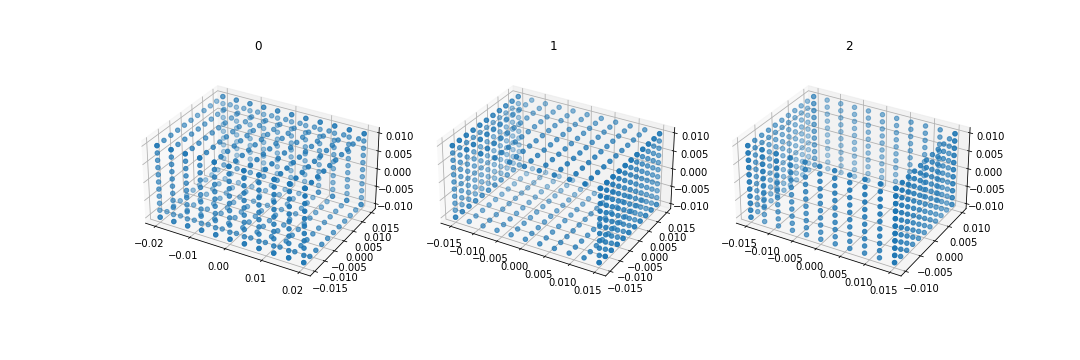

In [217]:
fig = plt.figure(figsize=(15,5))

for i, data in enumerate([eval_x, eval_y, eval_z]):
  ax = fig.add_subplot(1, 3, i+1, projection='3d')
  ax.set_box_aspect(obj_shape)
  ax.scatter(data[:,0].numpy(), data[:,1].numpy(), data[:,2].numpy())
  ax.title.set_text(f'{i}')

In [218]:
for data in [eval_x, eval_y, eval_z]:
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
    distri = model(data/obj_shape)
    f_test = likelihood(distri)
    print(f_test.mean.mean().item(), f_test.variance.mean().item())

0.01085495576262474 0.03500671312212944
-0.029567215591669083 0.03901567682623863
-0.09161727875471115 0.04572468250989914


In [219]:
obj_test = x_test_view*obj_shape 

mean = b_test.mean.view(resolusion+1, resolusion+1, resolusion+1)
var = b_test.variance.view(resolusion+1, resolusion+1, resolusion+1)

In [220]:
box = torch.cat((
  yp_face, yn_face, zp_face, zn_face
), dim=0)*obj_shape*1.05
box = torch.cat([box, torch.ones((box.shape[0],1))],dim=-1)

In [221]:
theta = torch.linspace(-np.pi/2, np.pi/2, steps=11)
phi = torch.linspace(-np.pi, np.pi, steps=21)
theta, phi = torch.meshgrid(theta, phi)
rot_mat = torch.eye(4).repeat(11, 21, 1, 1)

rot_mat[:,:,0,0] = torch.cos(phi)
rot_mat[:,:,0,1] = torch.zeros_like(theta)
rot_mat[:,:,0,2] = -torch.sin(phi)

rot_mat[:,:,1,0] = -torch.sin(theta)*torch.sin(phi)
rot_mat[:,:,1,1] = torch.cos(theta)
rot_mat[:,:,1,2] = -torch.sin(theta)*torch.cos(phi)

rot_mat[:,:,2,0] = torch.cos(theta)*torch.sin(phi)
rot_mat[:,:,2,1] = torch.sin(theta)
rot_mat[:,:,2,2] = torch.cos(theta)*torch.cos(phi)

In [222]:
rot_x = (rot_mat@box.transpose(0,1)).transpose(-1,-2)
rot_x = rot_x[..., :3]

In [223]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  distri = model(rot_x/obj_shape)
  b_rot = b_like(distri)

In [224]:
log_prob = torch.log(b_rot.mean).sum(dim=-1)
var = b_rot.variance.mean(dim=-1)

<AxesSubplot:>

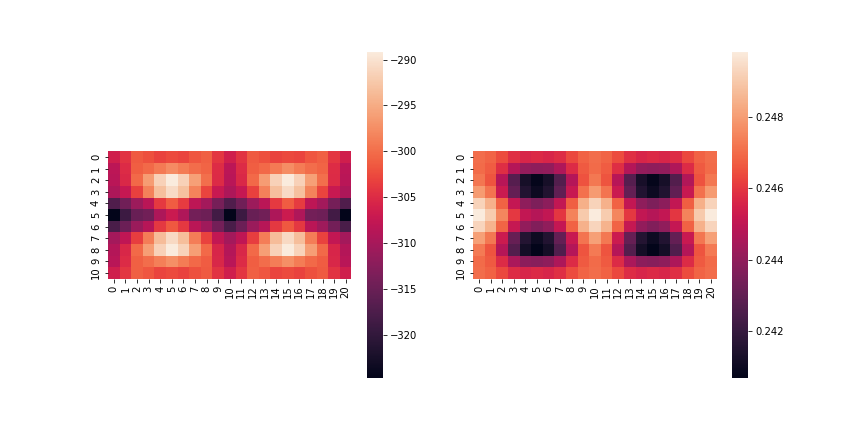

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(log_prob.numpy(), ax=axes[0], square=True)
sns.heatmap(var.numpy(), square=True,  ax=axes[1])